# 定义相关函数

In [23]:
#获取基本面数据
def get_data(ID,ID_name):
    df_getdata = w.edb(ID,"20091001","20211031","Period=M;Days=Alldays;Fill=Previous",usedf = True)[1]
    df_getdata.columns = ID_name
    return df_getdata

#计算指标的同比
def df_yoy(ID_code):
    yoy_code = [dictionary[i] for i in ID_code]
    df_yoy = w.edb(yoy_code,"20091001","20211031","Period=M;Days=Alldays;Fill=Previous",usedf = True)[1]
    df_yoy.columns = ID_code
    for i in range(len(yoy_code)):
        df_yoy[ID_code[i]+'同比'] = df_yoy[[ID_code[i]]].pct_change(periods = 12)
        del df_yoy[ID_code[i]]
    return df_yoy

#获取收益率序列
def df_return(industry):
    df_return = w.wsd(industry, "close", "20090901", "20211231", "Period=M;Days=Alldays;Fill=Previous",usedf = True)[1].pct_change()
    df_return.columns = ['return']
    return df_return

#计算分位数
def rank_pct(alist):
    alist_sort = list(np.sort(alist))
    result = [alist_sort.index(i)/(len(alist)-1) for i in alist]
    return result

#ty = 1为连续上涨，ty = 0为连续下跌
def compare(alist,ty):
    s = 0
    if ty == 1:
        for i in range(len(alist)-1):
            if alist[i] >= alist[i+1]:
                s = s+1
    elif ty == 0:
        for i in range(len(alist)-1):
            if alist[i] <= alist[i+1]:
                s = s+1
    return s

In [24]:
#计算指标的信号
def event(alist):
    K1,K2,K3,K4,K5 = [],[],[],[],[]
    
    #获取序列的分位数
    alist_drop = pd.DataFrame(alist).dropna().iloc[:,0].tolist()
    alist_drop_chg = pd.DataFrame(alist).dropna().pct_change(periods = 1).dropna().iloc[:,0].tolist()
    if len(alist_drop) == len(alist):
        rank = rank_pct(alist)
    elif len(alist_drop) != len(alist):
        rank = [0.5 for i in range(len(alist) - len(alist_drop))] + rank_pct(alist_drop)
    rank_chg = [0.5 for i in range(len(alist) - len(alist_drop_chg))] + rank_pct(alist_drop_chg)
        
    for i in range(len(alist)):
        #获得信号K1
        if rank[i] < 0.3:
            k1 = -1
        elif 0.3<= rank[i] <=0.7:
            k1 = 0
        elif rank[i] > 0.7:
            k1 = 1
        K1.append(k1)
        
        #获得信号K2
        if i == 0:
            k2 = 0
        elif np.isnan(alist[i-1]):
            k2 = 0
        elif alist[i] - alist[i-1] > 0:
            k2 = 1
        elif alist[i] - alist[i-1] < 0:
            k2 = -1
        elif alist[i] == alist[i-1] == 0:
            k2 = 0
        K2.append(k2) 
        
        #获得信号K3
        if i <= 3:
            k3 = 0
        elif np.isnan(alist[i-3]):
            k3 = 0
        elif compare(alist[i-3:i+1],1) == 0:#因子值连续上涨3个月
            k3 = 1
        elif compare(alist[i-3:i+1],0) == 0:#因子值连续下跌3个月
            k3 = -1
        else:
            k3 = 0
        K3.append(k3)
        
        #获得信号K4
        if i <= 3:
            k4 = 0
        elif np.isnan(alist[i-3]):
            k4 = 0
        elif compare(alist[i-3-1:i],1) == 0 and alist[i] < alist[i-1]:#因子值连续上涨3个月后最新一期下跌
            k4 = -1 
        elif compare(alist[i-3-1:i],0) == 0 and alist[i] > alist[i-1]:#因子值连续下跌3个月后最新一期上涨
            k4 = 1
        else:
            k4 = 0
        K4.append(k4)
        
        #获得信号K5
        if rank_chg[i] > 0.8:
            k5 = 1
        elif rank_chg[i] < 0.2:
            k5 = -1
        elif 0.2 <= rank_chg[i] <=0.8:
            k5 = 0
        K5.append(k5)
        
    return K1,K2,K3,K4,K5

In [25]:
#回测结果函数
def result_fun(return_list,rate_list):
    result = []
    i = np.argmax((np.maximum.accumulate(return_list)- return_list)/np.maximum.accumulate(return_list))
    if i == 0:
        return 0
    j = np.argmax(return_list[:i])    
    MaxDrawdown = -(return_list[j] - return_list[i]) / return_list[j]
    return_year = pow(return_list[-1],12/len(return_list))-1
    volatility = np.std(np.array(rate_list) - 1)*pow(12,0.5)   
    result.append(return_list[-1])
    result.append(return_year*100)
    result.append(volatility*100)
    result.append(MaxDrawdown*100)
    result.append(result[1]/result[2])    
    result = pd.DataFrame(result).T
    result.columns = ['净值','年化收益率','年化波动率','最大回撤','夏普比率']    
    return result

# 获取行业数据

In [26]:
from WindPy import w
import pandas as pd
import numpy as np
from tqdm import trange
w.start()
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [27]:
ID_name = '社会消费品零售总额:当月同比,消费者信心指数(月),CPI:当月同比,36大中城市日用工业消费品平均价格:空调机:1.5匹冷暖,36大中城市日用工业消费品平均价格:洗衣机:波轮式(5kg),36大中城市日用工业消费品平均价格:洗衣机:滚筒式(5kg),36大中城市日用工业消费品平均价格:冰箱:210-250立升,长江有色市场:平均价:铜:1,长江有色市场:平均价:铝:A00,价格:冷轧板卷:1.0mm:北京,价格:冷轧板卷:1.0mm:上海,价格:冷轧板卷:1.0mm:广州,中国塑料城价格指数,产量:空调:当月同比,产量:空调:累计同比,产量:家用洗衣机:当月同比,产量:家用洗衣机:累计同比,产量:家用电冰箱:当月同比,产量:家用电冰箱:累计同比,房屋竣工面积:累计同比,(停止)库存:家用空调:当月同比,(停止)库存:冰箱:当月同比,(停止)库存:洗衣机:当月同比,(停止)销量:家用空调:当月同比,(停止)内销量:家用空调:当月同比,(停止)销量:家用空调:累计同比,(停止)内销量:家用空调:累计同比,(停止)销量:冰箱:当月同比,(停止)内销量:冰箱:当月同比,(停止)销量:冰箱:累计同比,(停止)内销量:冰箱:累计同比,(停止)销量:洗衣机:当月同比,(停止)内销量:洗衣机:当月同比,(停止)销量:洗衣机:累计同比,(停止)内销量:洗衣机:累计同比'.split(',')
ID_code = 'M0001428,M0012303,M0000612,S6805558,S6805550,S6805551,S6805559,S0182161,S0182162,S0033141,S0033155,S0033145,S5431605,S0028203,S0028205,S0028211,S0028213,S0028207,S0028209,S0073297,S5616246,S5616354,S5616429,S5616250,S5616256,S5616254,S5616260,S5616358,S5616364,S5616362,S5616368,S5616433,S5616439,S5616437,S5616443'.split(',')
dictionary = dict(zip(ID_name,ID_code))
industry = '801111.SI'#白电行业

In [29]:
df = get_data(ID_code,ID_name)
df_m = df[['长江有色市场:平均价:铜:1','长江有色市场:平均价:铝:A00','价格:冷轧板卷:1.0mm:北京','价格:冷轧板卷:1.0mm:上海','价格:冷轧板卷:1.0mm:广州','中国塑料城价格指数']]
df_m = df_m.pct_change(periods = 12).dropna()+1
df_m['原材料价格指数'] = (df_m['长江有色市场:平均价:铜:1'] + df_m['长江有色市场:平均价:铝:A00'] + (df_m['价格:冷轧板卷:1.0mm:北京'] + df_m['价格:冷轧板卷:1.0mm:上海'] + df_m['价格:冷轧板卷:1.0mm:广州'])/3 + df_m['中国塑料城价格指数'])/4 
df = df.iloc[:,0:7].join(df.iloc[:,13:])
df = df.join(df_m[['原材料价格指数']])
df = df.join(df_yoy(['36大中城市日用工业消费品平均价格:空调机:1.5匹冷暖','36大中城市日用工业消费品平均价格:洗衣机:波轮式(5kg)','36大中城市日用工业消费品平均价格:洗衣机:滚筒式(5kg)','36大中城市日用工业消费品平均价格:冰箱:210-250立升'])*100)
df = df.iloc[:,0:3].join(df.iloc[:,7:])

In [30]:
#收益率数据向后平移两期
df = df_return(industry).dropna().shift(-2).join(df).iloc[:-2,:]

In [31]:
df

,return,社会消费品零售总额:当月同比,消费者信心指数(月),CPI:当月同比,产量:空调:当月同比,产量:空调:累计同比,产量:家用洗衣机:当月同比,产量:家用洗衣机:累计同比,产量:家用电冰箱:当月同比,产量:家用电冰箱:累计同比,房屋竣工面积:累计同比,(停止)库存:家用空调:当月同比,(停止)库存:冰箱:当月同比,(停止)库存:洗衣机:当月同比,(停止)销量:家用空调:当月同比,(停止)内销量:家用空调:当月同比,(停止)销量:家用空调:累计同比,(停止)内销量:家用空调:累计同比,(停止)销量:冰箱:当月同比,(停止)内销量:冰箱:当月同比,(停止)销量:冰箱:累计同比,(停止)内销量:冰箱:累计同比,(停止)销量:洗衣机:当月同比,(停止)内销量:洗衣机:当月同比,(停止)销量:洗衣机:累计同比,(停止)内销量:洗衣机:累计同比,原材料价格指数,36大中城市日用工业消费品平均价格:空调机:1.5匹冷暖同比,36大中城市日用工业消费品平均价格:洗衣机:波轮式(5kg)同比,36大中城市日用工业消费品平均价格:洗衣机:滚筒式(5kg)同比,36大中城市日用工业消费品平均价格:冰箱:210-250立升同比
2009-10-31,0.053849,16.200000,103.20,-0.500000,36.2000,-10.1000,31.4000,11.0000,21.9000,16.7000,22.7,-22.07,-69.12,9.71,68.19,97.79,-4.83,21.77,26.81,45.86,27.71,44.80,8.98,13.45,2.19,10.25,NaN,NaN,NaN,NaN,NaN
2009-11-30,-0.123718,15.800000,103.30,0.600000,57.7000,-6.4000,30.2000,13.1000,30.6000,17.6000,26.1,-15.38,-55.82,8.85,63.40,74.28,-1.98,24.65,64.27,101.32,29.80,47.63,18.35,19.58,3.54,11.05,NaN,NaN,NaN,NaN,NaN
2009-12-31,0.082472,17.500000,103.90,1.900000,40.7000,-4.1000,11.7000,13.0000,31.1000,18.8000,9.2,-9.69,-52.75,11.62,56.15,65.18,0.88,27.06,75.20,96.99,32.58,50.71,24.67,11.31,5.26,11.08,NaN,NaN,NaN,NaN,NaN
2010-01-31,0.046320,14.000000,104.70,1.500000,94.2732,94.2732,73.7015,73.7015,80.8772,80.8772,9.2,-2.87,-58.00,10.58,58.41,89.41,58.41,89.41,82.71,103.25,82.71,103.25,29.95,22.80,29.95,22.80,NaN,NaN,NaN,NaN,NaN
2010-02-28,-0.145462,22.100000,104.20,2.700000,-9.5000,27.7000,22.7000,47.5000,21.1000,45.8000,8.2,2.12,-56.41,2.18,9.12,18.54,30.30,49.49,49.32,58.97,65.59,80.24,27.54,21.40,28.85,22.15,NaN,NaN,NaN,NaN,NaN
2010-03-31,-0.058217,18.000000,107.90,2.400000,24.4000,30.0000,28.7000,40.7000,8.6000,27.4000,12.0,0.64,-46.70,-6.87,42.64,59.06,35.84,54.07,14.51,24.04,41.69,53.93,26.03,17.99,27.85,20.77,NaN,NaN,NaN,NaN,NaN
2010-04-30,-0.062398,18.500000,106.60,2.800000,27.5000,30.0000,34.4000,39.7000,29.7000,28.5000,13.5,2.02,-48.38,-11.12,41.81,45.56,37.72,51.22,40.17,49.54,41.23,52.60,25.20,20.10,27.13,20.59,NaN,NaN,NaN,NaN,NaN
2010-05-31,0.186902,18.660000,108.00,3.100000,69.9000,38.6000,30.9000,37.9000,30.5000,29.3000,18.1,3.53,-24.38,-18.59,62.69,56.64,43.25,52.60,11.71,9.08,33.91,41.94,19.91,9.62,25.71,18.53,NaN,NaN,NaN,NaN,NaN
2010-06-30,0.058391,18.300000,108.50,2.900000,47.3000,39.5000,24.1000,35.8000,23.5000,28.2000,18.2,15.35,-21.74,-22.28,26.05,-4.46,39.89,37.86,9.88,14.66,28.87,36.43,32.32,28.17,26.73,19.93,NaN,NaN,NaN,NaN,NaN
2010-07-31,-0.005736,17.900000,107.80,3.300000,45.6000,38.4000,45.4000,36.9000,20.0000,26.8000,12.6,26.43,-26.52,-27.98,28.16,6.48,38.22,31.82,3.69,5.82,24.27,30.96,22.37,15.51,26.10,19.34,NaN,NaN,NaN,NaN,NaN


# 简单逻辑演绎回测

In [32]:
a = df['(停止)销量:家用空调:当月同比'].tolist()
b = df['(停止)销量:冰箱:当月同比'].tolist()
c = df['(停止)销量:洗衣机:当月同比'].tolist()
d = df['原材料价格指数'].tolist()

In [33]:
#空调、冰箱、洗衣机的销售额大致为2:1;1
signal = 0.8*np.array(pd.DataFrame(event(a)).sum().tolist()) - 0.2*np.array(pd.DataFrame(event(d)).sum().tolist())

In [34]:
index_rate = df['return'].tolist()
rate_me = []
rate_index = []

for i in range(len(signal)):
    if signal[i] > 0:
        rate = 1 + index_rate[i]
    elif signal[i] < 0:
        rate = 1
    rate_me.append(rate)
    rate_index.append(1 + index_rate[i])
    
value_me = [1]
value_index = [1]
for i in range(len(rate_me)):
    value_me.append(value_me[i]*rate_me[i])
    value_index.append(value_index[i]*rate_index[i])

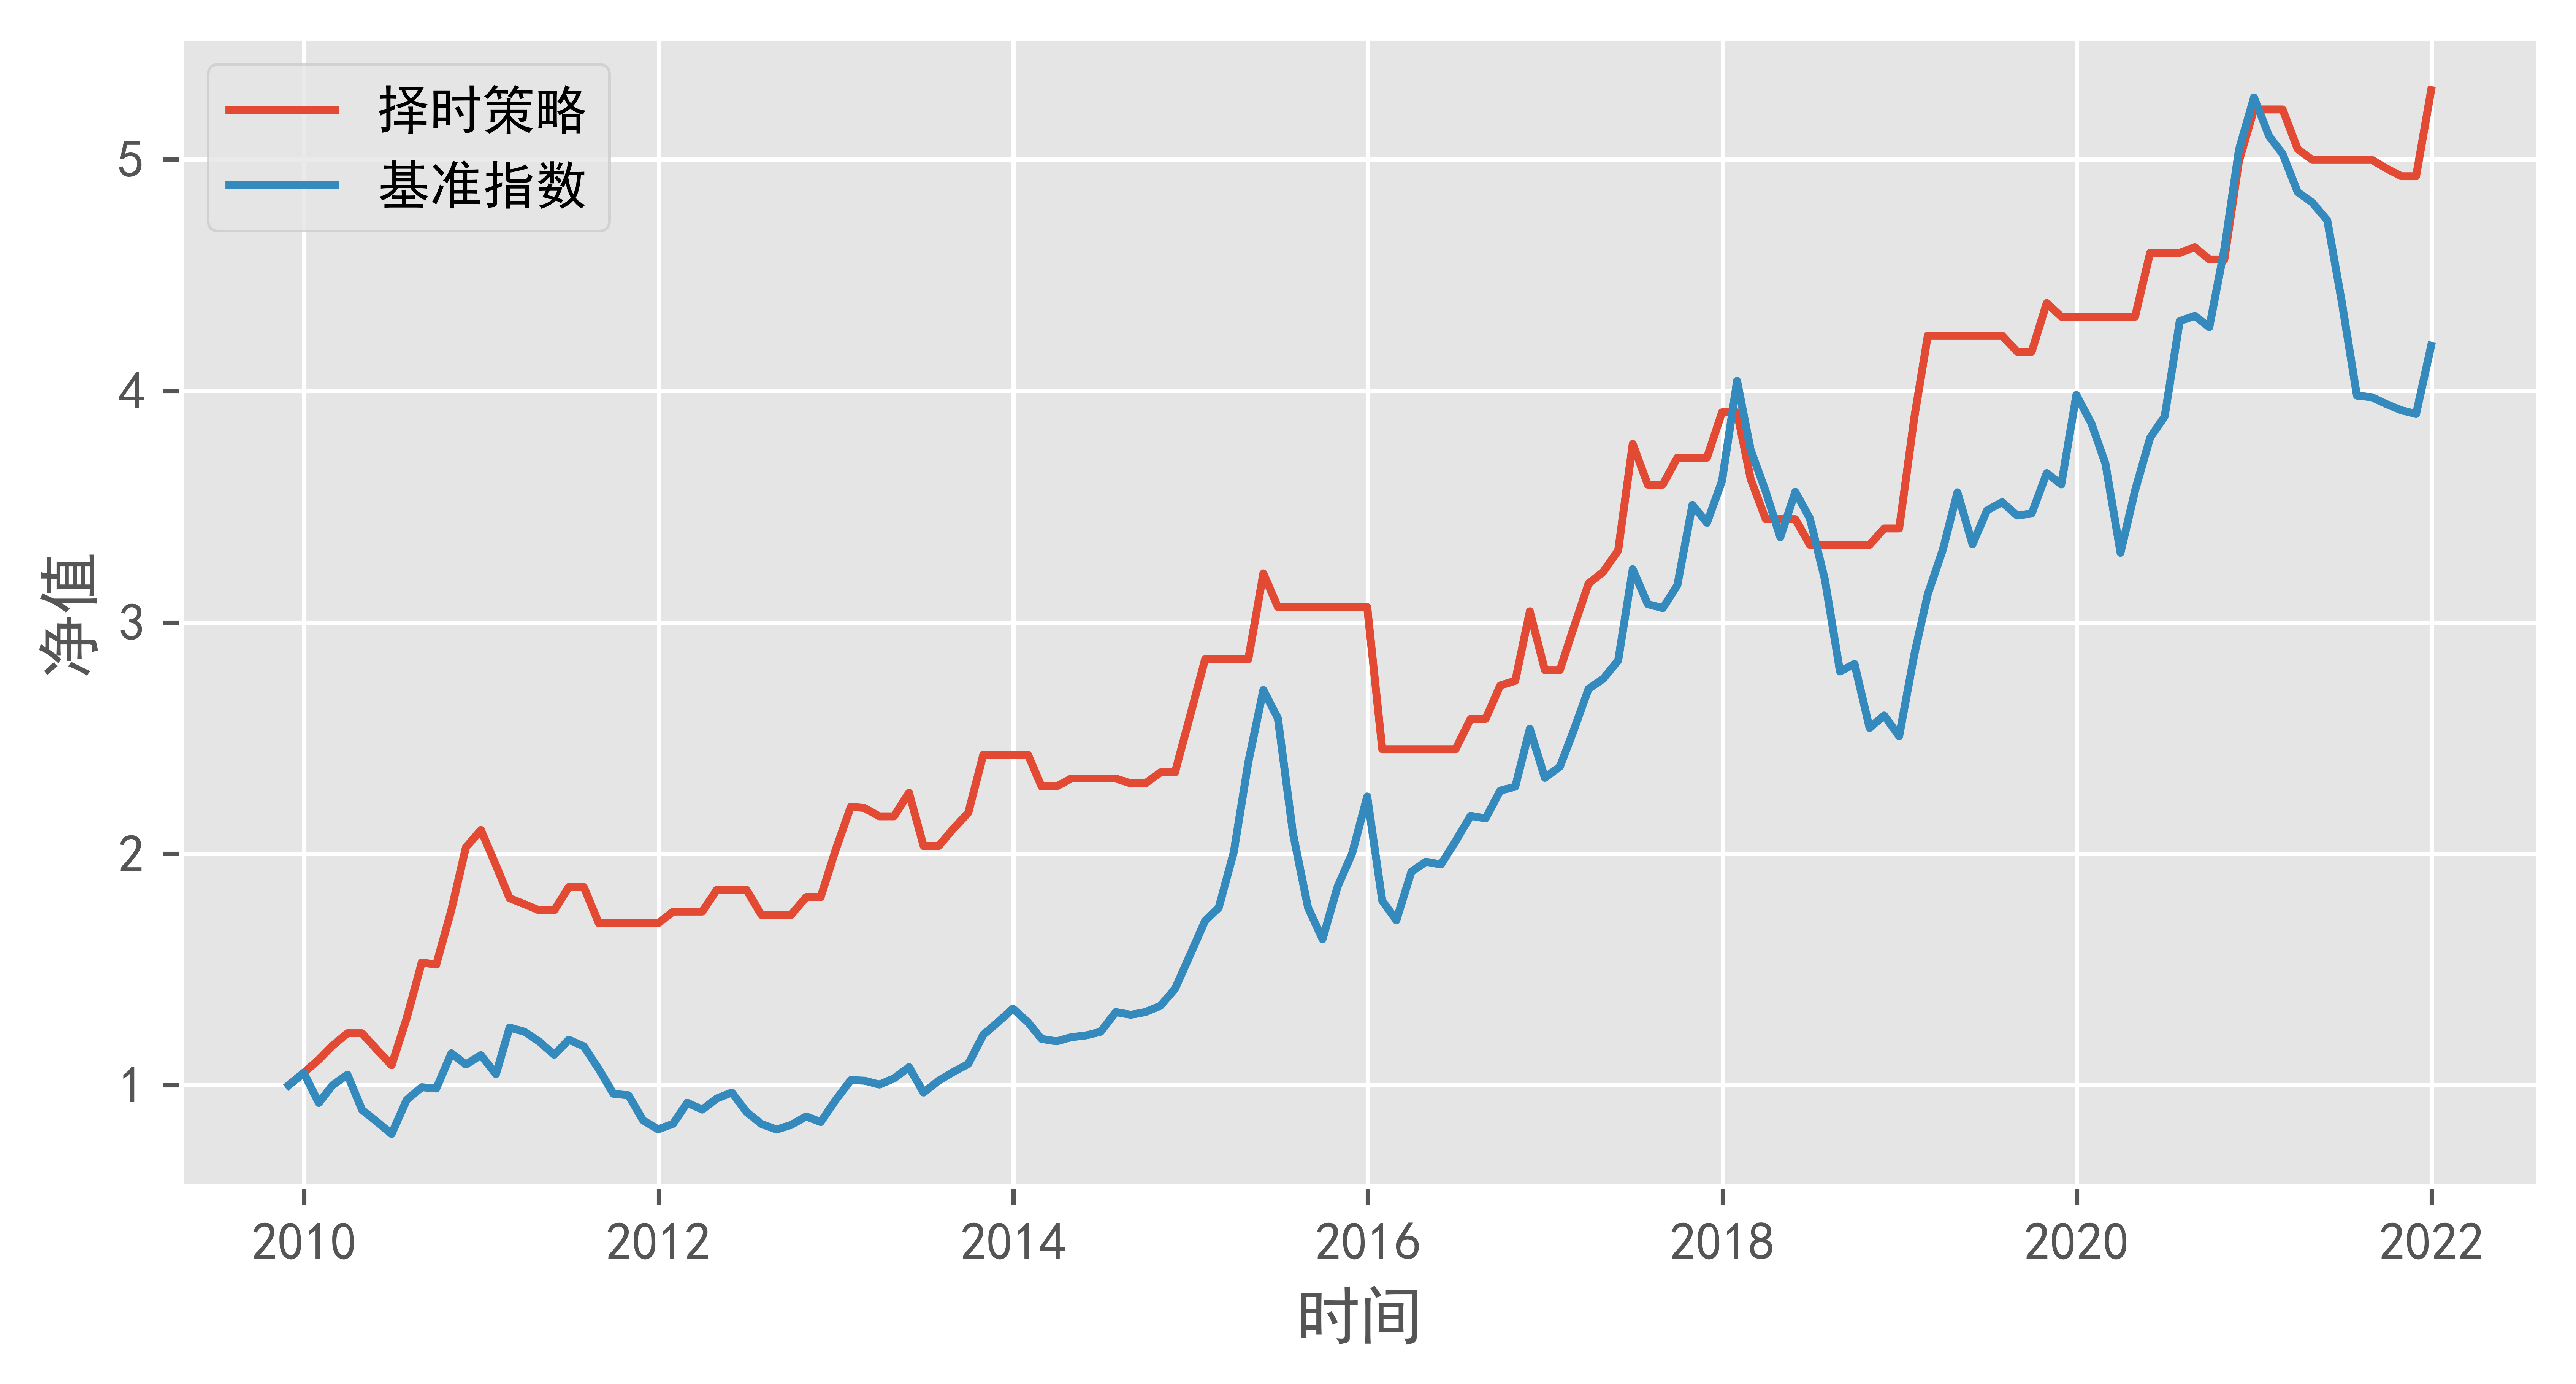

In [35]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.figure(figsize = (8,4),dpi = 1000)
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False 
plt.xlabel('时间')
plt.ylabel('净值')
plt.plot(pd.DataFrame(value_me,index = pd.date_range("2009-11-30",periods = len(value_me), freq="M")),label = '择时策略')
plt.plot(pd.DataFrame(value_index,index = pd.date_range("2009-11-30",periods = len(value_me), freq="M")),label = '基准指数')
plt.legend()

In [36]:
df_result = pd.concat([result_fun(value_me,rate_me),result_fun(value_index,rate_index)])
df_result.index = ['简单逻辑','白电指数']

In [37]:
df_result

,净值,年化收益率,年化波动率,最大回撤,夏普比率
简单逻辑,5.299106,14.689458,18.145644,-23.668796,0.809531
白电指数,4.194742,12.507442,26.000314,-39.765420,0.481050


# 择时策略回测

In [40]:
index,win_rate,count,profit_loss,record = [],[],[],[],[]
for i in trange(1,df.shape[1]):    
    for j in range(5):
        if df.columns[i] != '原材料价格指数':
            df_check = pd.concat([pd.DataFrame(event(df.iloc[:,i].tolist()[:87])[j]),pd.DataFrame(df['return'].tolist()[:87])],axis = 1)
        elif df.columns[i] == '原材料价格指数':
            df_check = pd.concat([pd.DataFrame(-1*np.array(event(df.iloc[:,i].tolist()[:87])[j])),pd.DataFrame(df['return'].tolist()[:87])],axis = 1)
        df_check.columns = ['signal','rate']
        df_check['win'] = df_check['rate'].apply(lambda x: 1 if x > 0 else 0)
        #计算胜率
        try:
            win_rate.append(df_check.groupby('signal').agg('mean')['win'][1])
        except:
            win_rate.append(np.nan)
            
        #计算历史发生次数
        try:
            count.append(pd.DataFrame(event(df.iloc[:,i].tolist()[:87])[j]).value_counts()[1])
        except:
            count.append(np.nan)
            
        #计算盈亏比
        try:
            profit_loss.append(abs(df_check[df_check['signal'] == 1].groupby('win').agg('mean')['rate'].pct_change(periods = 1)[1]+1))
        except:
            profit_loss.append(np.nan)
            
        index_name = df.columns[i]
        if j == 0:
            index.append(index_name + '；处于历史较高位置')
        elif j == 1:
            index.append(index_name + '；本月较上月变动大于0')
        elif j == 2:
            index.append(index_name + '；连续三个月上涨')
        elif j == 3:
            index.append(index_name + '；连续三个月下跌后上涨')
        elif j == 4:
            index.append(index_name + '；月涨跌幅处于历史80%以上 ')
        record.append([i,j])

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.33it/s]


In [41]:
df_event = pd.concat([pd.DataFrame(index),pd.DataFrame(count),pd.DataFrame(win_rate),pd.DataFrame(profit_loss),pd.DataFrame(record)],axis = 1)
df_event.columns = ['信号名称','历史触发次数','胜率','盈亏比','指标索引','信号索引']
df_event_effect = df_event[(df_event['历史触发次数'] > 7) & (df_event['胜率'] > 0.7) & (df_event['盈亏比'] > 1.5)]

In [42]:
df_event_effect

,信号名称,历史触发次数,胜率,盈亏比,指标索引,信号索引
77,(停止)销量:家用空调:累计同比；连续三个月上涨,14.0,0.714286,2.804160,16,2
99,(停止)销量:冰箱:累计同比；月涨跌幅处于历史80%以上,17.0,0.764706,2.365873,20,4
127,原材料价格指数；连续三个月上涨,8.0,0.800000,1.524207,26,2
135,36大中城市日用工业消费品平均价格:洗衣机:波轮式(5kg)同比；处于历史较高位置,11.0,0.818182,4.378184,28,0


In [43]:
index_id = df_event_effect['指标索引'].tolist()
sig = df_event_effect['信号索引'].tolist()
sig_all = []
for i in range(len(index_id)):
    if index_id[i] == 26:
        sig_all.append(-1*np.array(event(df.iloc[:,index_id[i]].tolist()[87:])[sig[i]]))
    elif index_id[i] != 26:
        sig_all.append(event(df.iloc[:,index_id[i]].tolist()[87:])[sig[i]])
signal = pd.DataFrame(sig_all).replace(-1,0).sum().tolist()

In [45]:
index_rate = df['return'].tolist()[87:]
rate_me = []
rate_index = []

for i in range(len(signal)):
    if signal[i] > 0:
        rate = 1 + index_rate[i]
    elif signal[i] == 0:
        rate = 1
    rate_me.append(rate)
    rate_index.append(1 + index_rate[i])
    
value_me = [1]
value_index = [1]
for i in range(len(rate_me)):
    value_me.append(value_me[i]*rate_me[i])
    value_index.append(value_index[i]*rate_index[i])

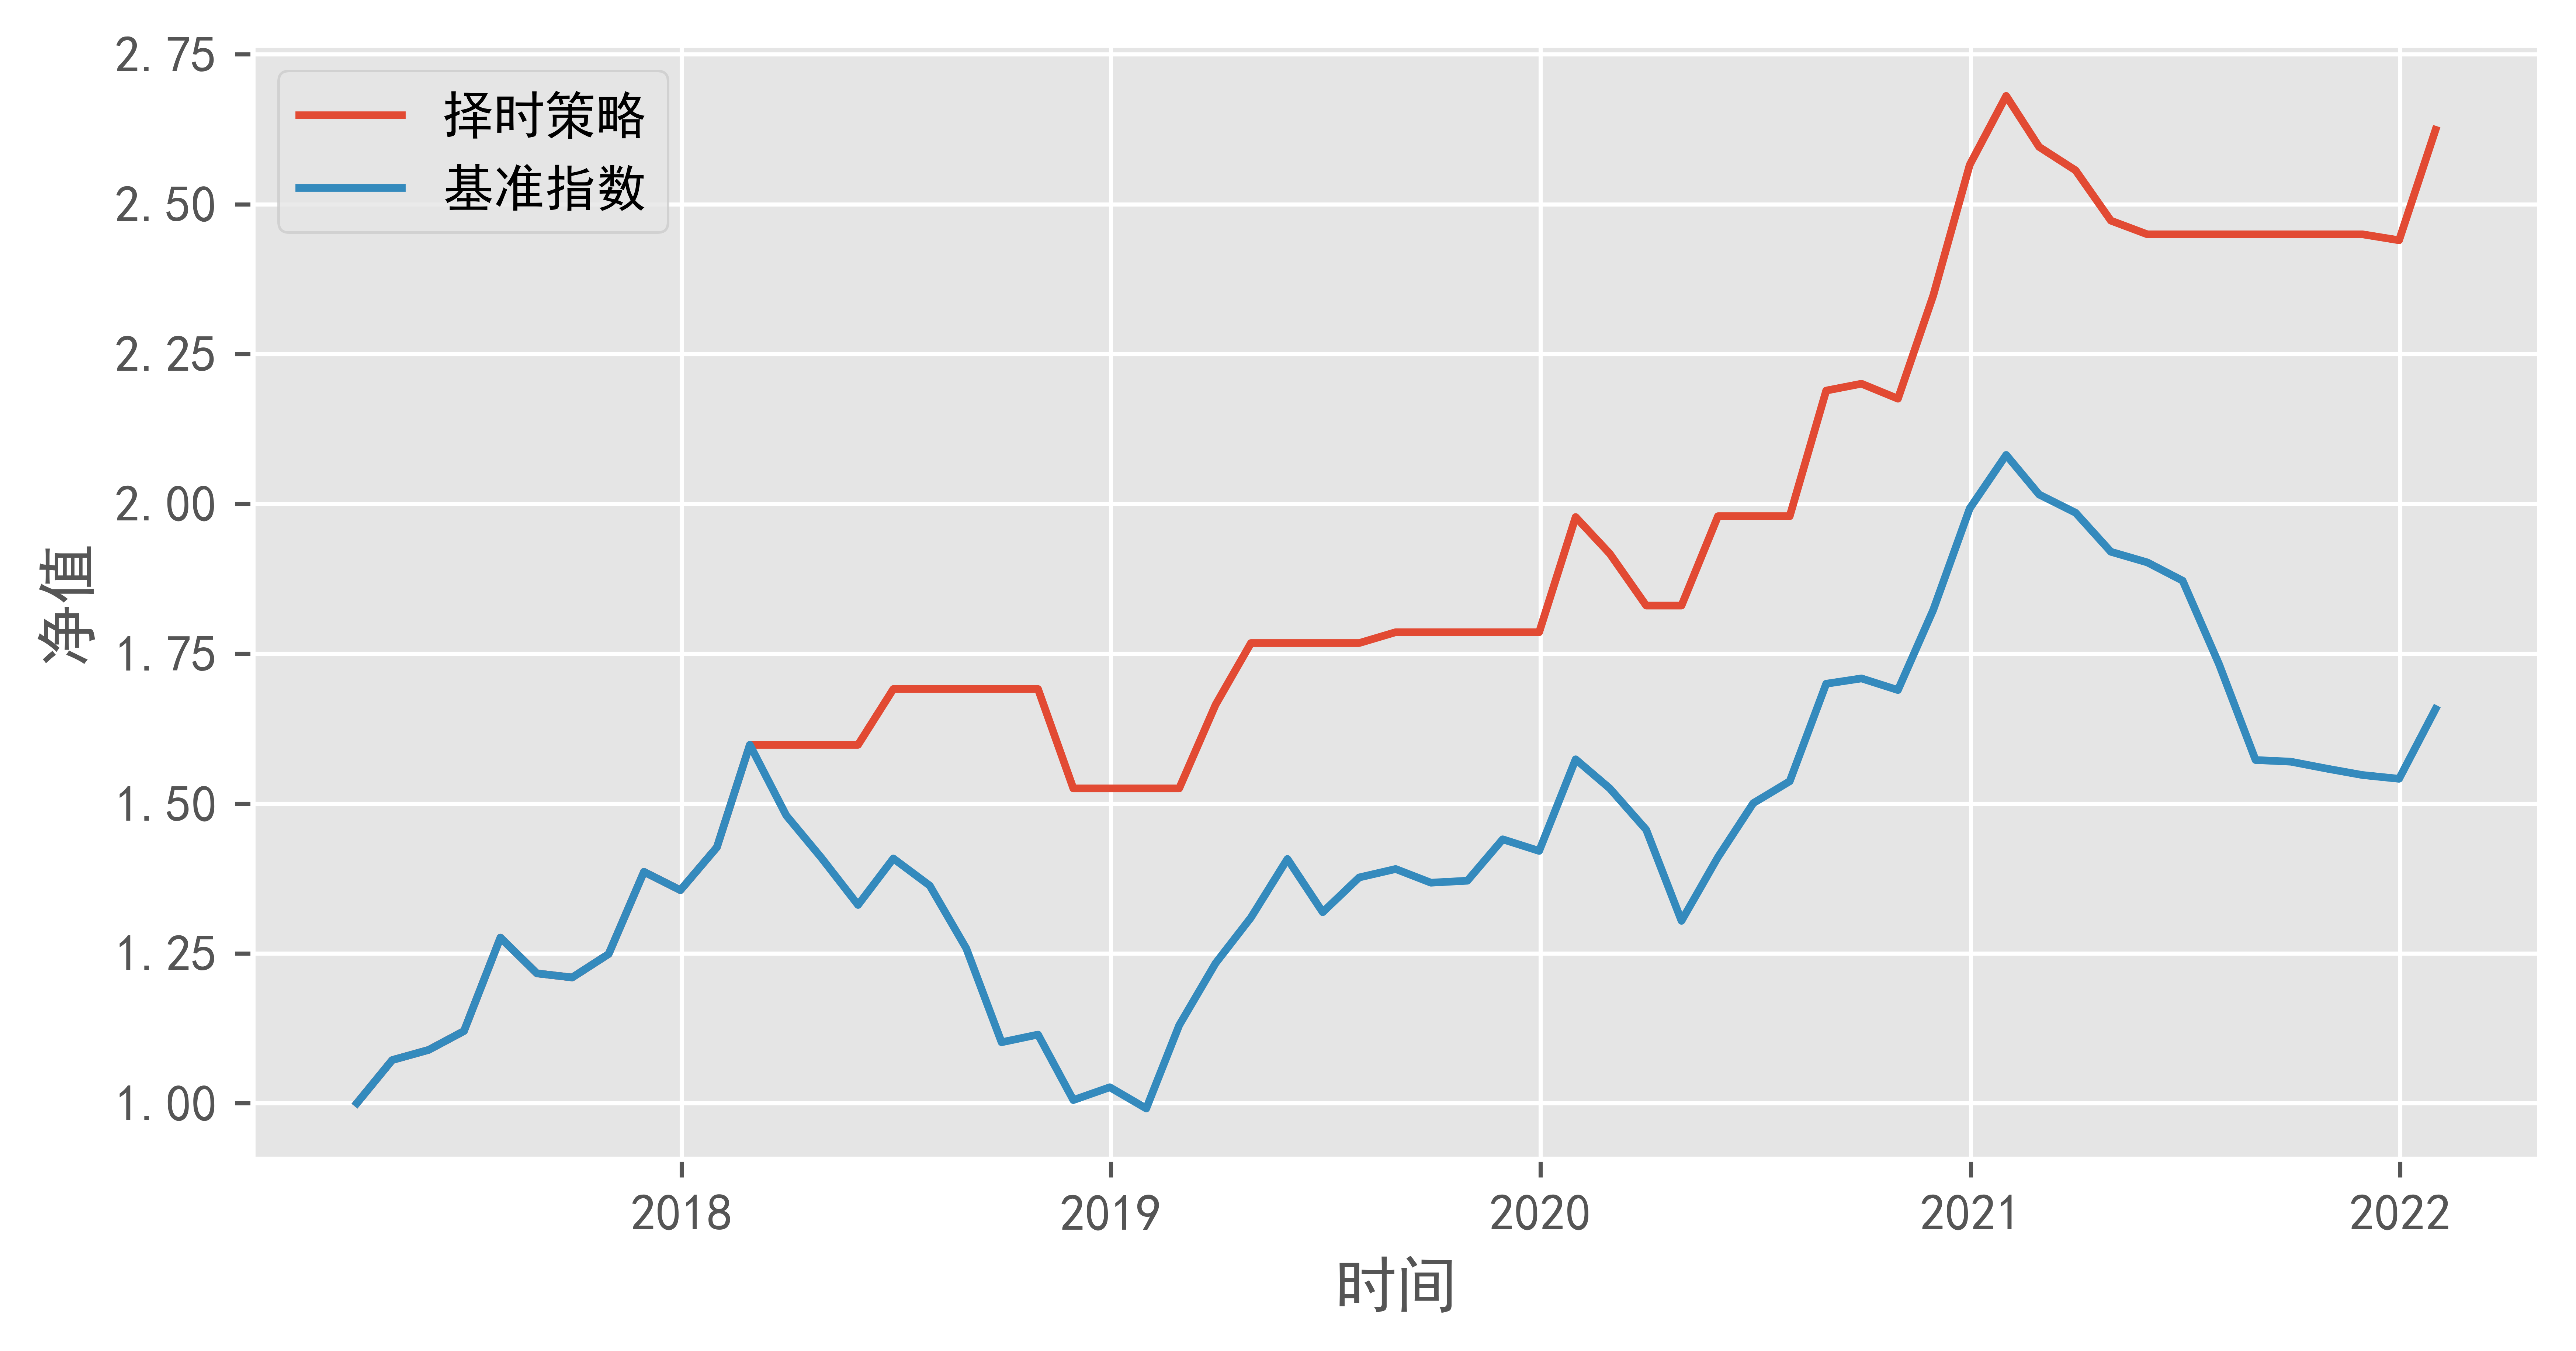

In [46]:
import matplotlib.pyplot as plt
plt.figure(figsize = (8,4),dpi = 1000)
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False 
plt.xlabel('时间')
plt.ylabel('净值')
plt.plot(pd.DataFrame(value_me,index = pd.date_range("2017-03-31",periods = len(value_me), freq="M")),label = '择时策略')
plt.plot(pd.DataFrame(value_index,index = pd.date_range("2017-03-31",periods = len(value_me), freq="M")),label = '基准指数')
plt.legend()

In [47]:
df_result = pd.concat([result_fun(value_me,rate_me),result_fun(value_index,rate_index)])
df_result.index = ['择时策略','白电指数']

In [48]:
df_result

,净值,年化收益率,年化波动率,最大回撤,夏普比率
择时策略,2.624145,21.679625,15.962515,-9.805951,1.358158
白电指数,1.657648,10.826219,22.001649,-37.976085,0.492064
